In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00


In [22]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    matthews_corrcoef,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import warnings
warnings.filterwarnings("ignore")

In [23]:
AA_ORDER = "ACDEFGHIKLMNPQRSTVWY"

def aa_composition(seq, n=22):
    """Return 20D amino acid composition of first n residues."""
    seq = seq[:n]
    if len(seq) == 0:
        return [0.0] * 20
    comp = ProteinAnalysis(seq).get_amino_acids_percent()
    return [comp.get(aa, 0.0) for aa in AA_ORDER]

def hydrophobicity_features(seq, window=5, n_region=40):
    """Return [mean, max] hydrophobicity (Kyte & Doolittle) over first n_region residues."""
    seq = seq[:n_region]
    if len(seq) < window:
        return [-10.0, -10.0]
    kd_scale = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.5, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    scores = []
    for i in range(len(seq) - window + 1):
        window_seq = seq[i:i + window]
        score = np.mean([kd_scale.get(aa, 0) for aa in window_seq])
        scores.append(score)
    return [np.mean(scores), np.max(scores)]

def charge_features(seq, n=10):
    """Return [pos_count, neg_count, net_charge] in first n residues."""
    sub = seq[:n]
    pos = sub.count('K') + sub.count('R')
    neg = sub.count('D') + sub.count('E')
    return [pos, neg, pos - neg]

def extract_features(df):
    """Extract full feature vector for each protein sequence."""
    features = []
    for seq in df['Sequence']:
        comp = aa_composition(seq, n=22)
        hydro = hydrophobicity_features(seq, window=5, n_region=40)
        charge = charge_features(seq, n=10)
        features.append(comp + hydro + charge)
    return np.array(features)

In [26]:
import pandas as pd
df = pd.read_csv("data.tsv", sep="\t")

# Validate required columns
assert 'Sequence' in df.columns, "Column 'Sequence' is missing!"
assert 'Label' in df.columns, "Column 'Label' is missing!"
assert set(df['Label'].unique()).issubset({'Positive', 'Negative'}), \
    "Labels must be 'Positive' or 'Negative' only."


# Clean data
df = df[df['Sequence'].str.len() > 0].reset_index(drop=True)
print(f"✅ Loaded {len(df)} samples: {sum(df['Label']=='Positive')} SP+, {sum(df['Label']=='Negative')} SP-")

✅ Loaded 10027 samples: 1093 SP+, 8934 SP-


In [27]:
# Full feature matrix
X_full = extract_features(df)
y = df['Label'].map({'Positive': 1, 'Negative': 0}).values

# Automatic feature selection using Random Forest
print("\n🔍 Performing automatic feature selection with Random Forest...")
rf_for_selection = RandomForestClassifier(n_estimators=200, random_state=42)
rf_for_selection.fit(X_full, y)

# Select top 15 most important features
selector = SelectFromModel(rf_for_selection, max_features=15, prefit=True)
X_selected = selector.transform(X_full)

# Feature names for reporting
feature_names = (
    [f"AA_{aa}" for aa in AA_ORDER] +
    ["Hydro_Mean", "Hydro_Max"] +
    ["Pos_Charge", "Neg_Charge", "Net_Charge"]
)
selected_names = np.array(feature_names)[selector.get_support()]
print("✅ Selected features:", list(selected_names))

# Standardize features (required for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)



🔍 Performing automatic feature selection with Random Forest...
✅ Selected features: [np.str_('AA_L'), np.str_('Hydro_Mean'), np.str_('Hydro_Max')]


In [29]:
# Define parameter grids for multiple kernels
param_grids = [
    {'kernel': ['linear'], 'C': [0.5, 1, 2, 4]},
    {'kernel': ['rbf'], 'C': [1, 2, 4, 8], 'gamma': [0.5, 1, 2, 'scale']},
    {'kernel': ['poly'], 'C': [1, 2], 'degree': [2, 3], 'gamma': ['scale', 1], 'coef0': [0, 1]},
    {'kernel': ['sigmoid'], 'C': [1, 2, 4], 'gamma': ['scale', 1], 'coef0': [0, 1]}
]

# Outer CV: 5-fold test split
outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
conf_matrices = []

print("\n🔄 Starting 5-fold nested cross-validation with multi-kernel grid search...")

for fold, (train_val_idx, test_idx) in enumerate(outer_skf.split(X_scaled, y)):
    print(f"\n=== FOLD {fold + 1} ===")

    X_train_val, X_test = X_scaled[train_val_idx], X_scaled[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # Inner CV: 4-fold hyperparameter tuning
    inner_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    best_score = -1
    best_model = None
    best_params = None

    for param_grid in param_grids:
        svm = SVC(probability=False)
        grid = GridSearchCV(
            svm,
            param_grid,
            cv=inner_skf,
            scoring='matthews_corrcoef',
            n_jobs=-1
        )
        grid.fit(X_train_val, y_train_val)

        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_model = grid.best_estimator_
            best_params = grid.best_params_
  # Evaluate on test set
    y_pred = best_model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Fold': fold + 1,
        'MCC': mcc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'Best_Params': best_params
    })
    conf_matrices.append(cm)

    print(f"✅ Test MCC: {mcc:.4f} | Kernel: {best_params['kernel']} | Params: {best_params}")


🔄 Starting 5-fold nested cross-validation with multi-kernel grid search...

=== FOLD 1 ===
✅ Test MCC: 0.6711 | Kernel: rbf | Params: {'C': 8, 'gamma': 0.5, 'kernel': 'rbf'}

=== FOLD 2 ===
✅ Test MCC: 0.6654 | Kernel: rbf | Params: {'C': 1, 'gamma': 2, 'kernel': 'rbf'}

=== FOLD 3 ===
✅ Test MCC: 0.6674 | Kernel: rbf | Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

=== FOLD 4 ===
✅ Test MCC: 0.6932 | Kernel: rbf | Params: {'C': 2, 'gamma': 2, 'kernel': 'rbf'}

=== FOLD 5 ===
✅ Test MCC: 0.7028 | Kernel: rbf | Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [30]:
res_df = pd.DataFrame(results)
print("\n" + "="*70)
print("✅ FINAL PERFORMANCE (5-FOLD NESTED CV WITH FEATURE SELECTION)")
print("="*70)
for col in ['MCC', 'Accuracy', 'Precision', 'Recall']:
    mean_val = res_df[col].mean()
    std_val = res_df[col].std()
    print(f"{col:10}: {mean_val:.4f} ± {std_val:.4f}")

# Average confusion matrix
avg_cm = np.mean(conf_matrices, axis=0).astype(int)
print("\nAverage Confusion Matrix:")
print(avg_cm)

# Best kernel distribution
kernels = [r['Best_Params']['kernel'] for r in results]
print(f"\nMost selected kernels: {pd.Series(kernels).value_counts().to_dict()}")


✅ FINAL PERFORMANCE (5-FOLD NESTED CV WITH FEATURE SELECTION)
MCC       : 0.6800 ± 0.0169
Accuracy  : 0.9404 ± 0.0029
Precision : 0.7519 ± 0.0128
Recall    : 0.6762 ± 0.0247

Average Confusion Matrix:
[[1738   48]
 [  70  147]]

Most selected kernels: {'rbf': 5}


Top 10 features by Gini importance:
      feature  importance
0   Hydro_Max    0.224542
1  Hydro_Mean    0.201223
2        AA_L    0.142154
3  Neg_Charge    0.038694
4        AA_R    0.034500
5        AA_A    0.031863
6  Net_Charge    0.030968
7        AA_F    0.023590
8        AA_V    0.021511
9        AA_P    0.021369


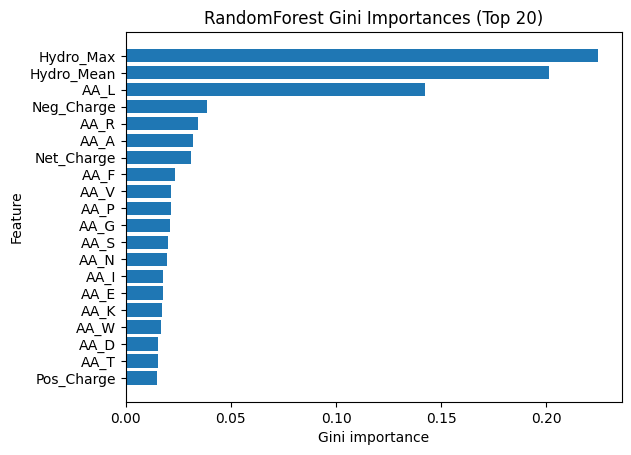

In [31]:
import matplotlib.pyplot as plt
gini_imp = pd.Series(rf_for_selection.feature_importances_, index=feature_names).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("Top 10 features by Gini importance:")
print(gini_df.head(10))

# Plot top 20
plt.figure()
plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances (Top 20)")
plt.show()